# LSST baseline_v4.0 Cadence

Baseline_v4.0 is the simulation of the survey strategy with which LSST will start its first few years.  While the MAF metrics provide statistics such as the median intra-night gap as a histogram and function of HEALpixel this notebook compares the realized cadence for specific regions of the Galactic Plane and Bulge, and explores the distribution of the visits in different years of the survey.

In [1]:
import os
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from astropy import units as u
from astropy.coordinates import SkyCoord
import rubin_sim.maf as maf
import rubin_sim.phot_utils as phot_utils
from rubin_sim.data import get_data_dir
from rubin_sim.data import get_baseline
from rubin_sim.phot_utils import signaltonoise, PhotometricParameters
from pyLIMA.simulations import simulator
from pyLIMA import event, toolbox
from pyLIMA import telescopes
from pyLIMA.models import PSPL_model
from pyLIMA.outputs import pyLIMA_plots
import pyLIMA.fits.objective_functions
from pyLIMA.toolbox import fake_telescopes, plots

%matplotlib inline

## Baseline_v4.0 simulation

To start with, we load the database of simulated observations from a realization of the LSST strategy.

In [2]:
# Load the opsim database
baseline_file = '/Users/rstreet/LSST/SCOC/baseline_v4.0_10yrs.db'
name = os.path.basename(baseline_file).replace('.db','')

outDir = 'temp'
resultsDb = maf.db.ResultsDb()

# This section selects which columns from the database will be loaded - in this case, the information on the 
# bandpass and MJD of each exposure, together with the 5sigma limiting magnitude.  
metric = maf.metrics.PassMetric(cols=['filter', 'observationStartMJD', 'fiveSigmaDepth'])
sql = ''

# Rubin filterset, and the single-visit limiting magnitude in each of those filters
filters = ['u', 'g', 'r', 'i', 'z', 'y']
mag_limit = {'u': 23.7, 'g': 24.97, 'r': 24.52, 'i': 24.13, 'z': 23.56, 'y': 22.55}

In [3]:
def get_slicer_timestamps(filters, dataSlice):
    """
    Function to extract the timestamps of observations for a specific target location from an opsim DB.
    """
    
    print('Total number of visits to this sky location over 10 yrs:')
    time_stamps = {}
    for f in filters:
        data = []
        # Observations in the current filter:
        fdx = np.where(dataSlice['filter'] == f)[0]
        print('  ' + f + ' n_visits= ' + str(len(fdx)))
        for i in fdx:
            jd = dataSlice['observationStartMJD'][i] + 2400000.5
            data.append(jd)
        time_stamps[f] = np.array(data)

    return time_stamps

## LSST cadence in the Plane and Bulge in different years

The Plane and Bulge receive different cadences as a matter of strategy and although the cadence is supposed to be similar in different years, here we explore how similar it is.

In [4]:
# Take target positions in the Plane and Bulge
plane_target = SkyCoord(281.1125, -13.88194, frame='icrs', unit=(u.deg, u.deg))
bulge_target = SkyCoord('18:03:04', '-28:36:39', frame='icrs', unit=(u.hourangle, u.deg))

In [5]:
# Create slicers for the survey HEALpixels corresponding to these targets
# Galactic Plane
plane_slicer = maf.slicers.UserPointsSlicer(ra=[plane_target.ra.deg], dec=[plane_target.dec.deg])
bundleList = [maf.MetricBundle(metric, plane_slicer, sql)]

# Run the chosen metrics for this slicer to get the opsim results for this target
bg = maf.MetricBundleGroup(
    bundleList, baseline_file, out_dir=outDir)
bg.run_all()
plane_dataSlice = bundleList[0].metric_values[0]

# Galactic Bulge
bulge_slicer = maf.slicers.UserPointsSlicer(ra=[bulge_target.ra.deg], dec=[bulge_target.dec.deg])
bundleList = [maf.MetricBundle(metric, bulge_slicer, sql)]

# Run the chosen metrics for this slicer to get the opsim results for this target
bg = maf.MetricBundleGroup(
    bundleList, baseline_file, out_dir=outDir)
bg.run_all()
bulge_dataSlice = bundleList[0].metric_values[0]

In [6]:
# Extract the timestamps of observations of these HEALpixels
print('Times of observations of the Plane field: ')
plane_time_stamps = get_slicer_timestamps(filters, plane_dataSlice)

print('Times of observations of the Bulge: ')
bulge_time_stamps = get_slicer_timestamps(filters, bulge_dataSlice)

Times of observations of the Plane field: 
Total number of visits to this sky location over 10 yrs:
  u n_visits= 17
  g n_visits= 150
  r n_visits= 158
  i n_visits= 155
  z n_visits= 150
  y n_visits= 35
Times of observations of the Bulge: 
Total number of visits to this sky location over 10 yrs:
  u n_visits= 22
  g n_visits= 309
  r n_visits= 326
  i n_visits= 409
  z n_visits= 332
  y n_visits= 28


Now let's visualize when these observations take place.  Firstly, we need to establish the boundary dates in JD for each year of the survey, bearing in mind that it may not start on Jan 1. 

In [7]:
# Calculate the earliest timestamp in the survey, noting this may not occur on Jan 1
tmin = 2e7
for f, visits in bulge_time_stamps.items():
    tmin = min(tmin, visits.min())

# From tmin, set boundary dates for each year in JD
NYEARS = 10
lsst_seasons = [[tmin + nyr*365, tmin + (nyr+1)*364] for nyr in range(0, NYEARS, 1)]
print(lsst_seasons)

[[2460815.8608590458, 2461179.8608590458], [2461180.8608590458, 2461543.8608590458], [2461545.8608590458, 2461907.8608590458], [2461910.8608590458, 2462271.8608590458], [2462275.8608590458, 2462635.8608590458], [2462640.8608590458, 2462999.8608590458], [2463005.8608590458, 2463363.8608590458], [2463370.8608590458, 2463727.8608590458], [2463735.8608590458, 2464091.8608590458], [2464100.8608590458, 2464455.8608590458]]


In [8]:
def calc_annual_visits(time_stamps, lsst_seasons):
    """Function to calculate the number of visits to a given field per year per filter"""

    annual_visits = {}

    for f, visits in time_stamps.items():
        nvisits = []
        for yr in range(0, NYEARS, 1):
            tidx1 = np.where(visits >= lsst_seasons[yr][0])[0]
            tidx2 = np.where(visits <= lsst_seasons[yr][1])[0]
            tidx = list(set(tidx1).intersection(set(tidx2)))
            nvisits.append(len(visits[tidx]))
        annual_visits[f] = nvisits

    return annual_visits

In [9]:
plane_annual_visits = calc_annual_visits(plane_time_stamps, lsst_seasons)
bulge_annual_visits = calc_annual_visits(bulge_time_stamps, lsst_seasons)

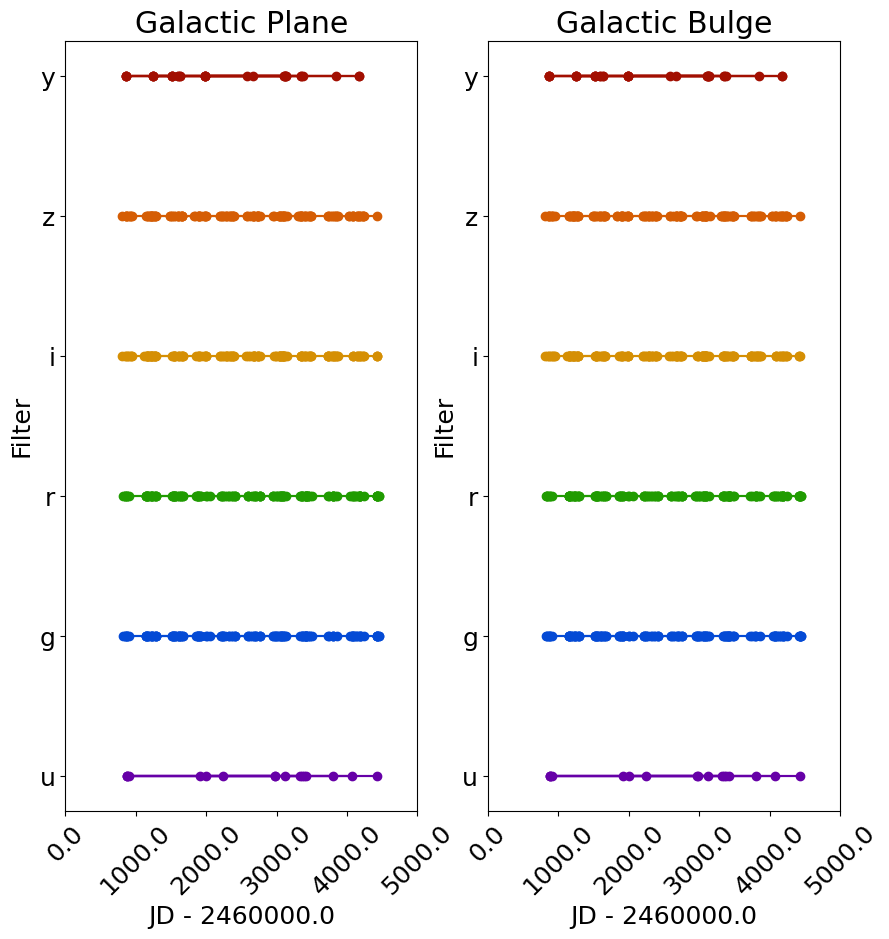

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(10,10))

plot_colours = {'u': '#6600a7', 'g': '#044ad5', 'r': '#209b01', 'i': '#d58f04', 'z': '#d55d04', 'y': '#a20f01'}
fontsize = 18
dt = 2460000.0

# TOP ROW OF PLOTS
# Plot timeline of Plane observations
yvalues = range(1,len(filters)+1,1)
for k,f in enumerate(filters):
    x = plane_time_stamps[f] - dt
    axs[0].plot(x, [yvalues[k]]*len(x), marker='o', color=plot_colours[f])

axs[0].set_xlabel('JD - 2460000.0', fontsize=fontsize)
axs[0].set_ylabel('Filter', fontsize=fontsize)
axs[0].set_title('Galactic Plane', fontsize=fontsize*1.2)
axs[0].set_yticks(yvalues, labels=filters, fontsize=fontsize)
xvalues = axs[0].get_xticks()
xlabels = [str(x) for x in xvalues]
axs[0].set_xticks(xvalues, labels=xlabels, rotation=45.0, fontsize=fontsize)


# Plot timeline of Bulge observations
yvalues = range(1,len(filters)+1,1)
for k,f in enumerate(filters):
    x = plane_time_stamps[f] - dt
    axs[1].plot(x, [yvalues[k]]*len(x), marker='o', color=plot_colours[f])

axs[1].set_xlabel('JD - 2460000.0', fontsize=fontsize)
axs[1].set_ylabel('Filter', fontsize=fontsize)
axs[1].set_title('Galactic Bulge', fontsize=fontsize*1.2)
axs[1].set_yticks(yvalues, labels=filters, fontsize=fontsize)
xvalues = axs[1].get_xticks()
xlabels = [str(x) for x in xvalues]
axs[1].set_xticks(xvalues, labels=xlabels, rotation=45.0, fontsize=fontsize)

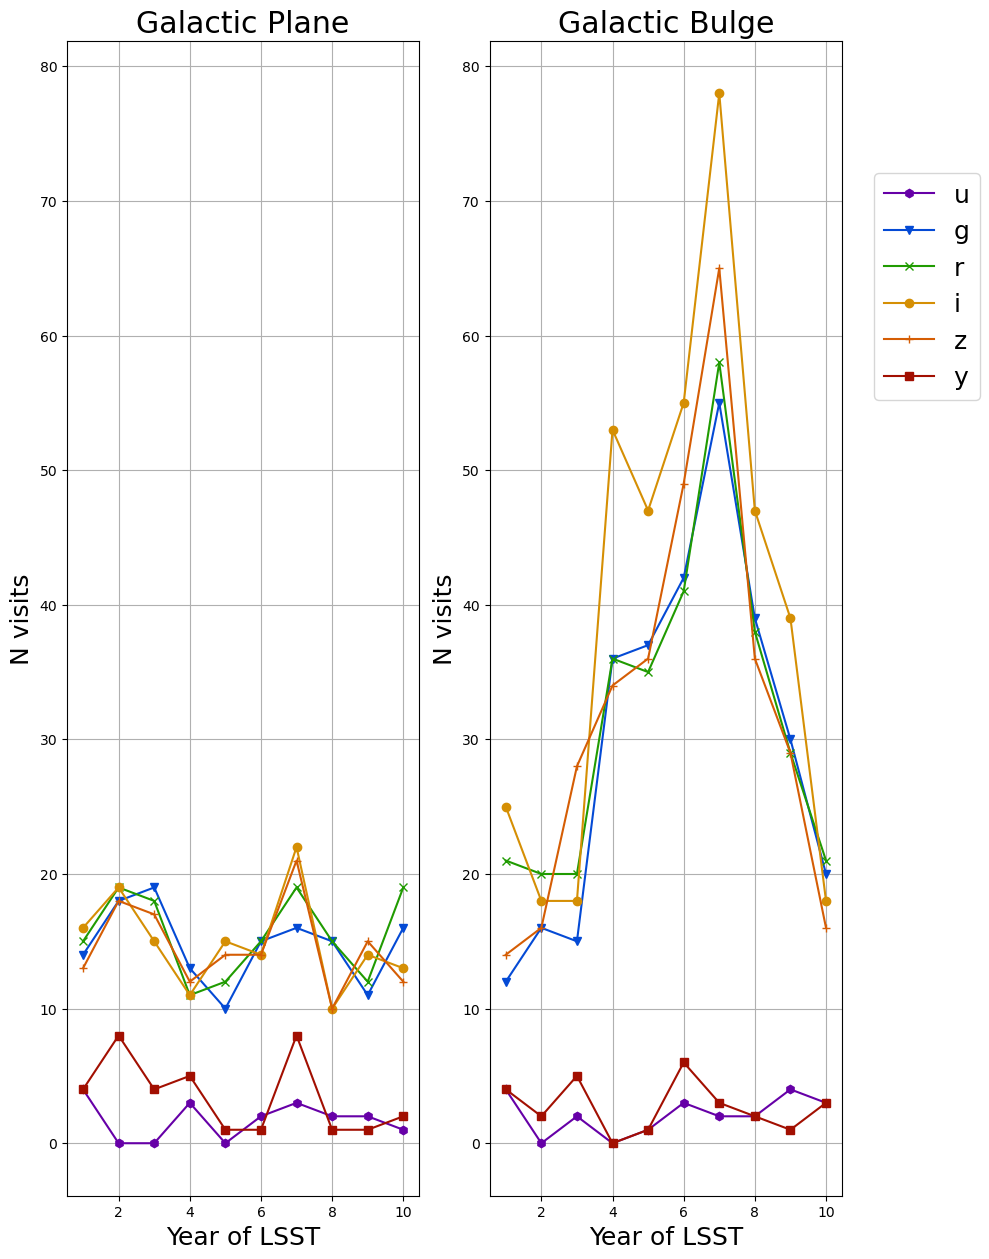

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(10,15))

plot_colours = {'u': '#6600a7', 'g': '#044ad5', 'r': '#209b01', 'i': '#d58f04', 'z': '#d55d04', 'y': '#a20f01'}
plot_markers = {'u': 'h', 'g': 'v', 'r': 'x', 'i': 'o', 'z': '+', 'y': 's'} 

fontsize = 18
dt = 2460000.0

# SECOND ROW OF PLOTS
# Plot of number of visits per year for the Plane
survey_years = range(1, 11, 1)
for k,f in enumerate(filters):
    axs[0].plot(survey_years, plane_annual_visits[f], label=f, marker=plot_markers[f], color=plot_colours[f])

    axs[0].set_xlabel('Year of LSST', fontsize=fontsize)
    axs[0].set_ylabel('N visits', fontsize=fontsize)
axs[0].set_title('Galactic Plane', fontsize=fontsize*1.2)
axs[0].grid()
plane_yrange = axs[0].get_ylim()

# Plot of number of visits per year for the Bulge
survey_years = range(1, 11, 1)
for k,f in enumerate(filters):
    axs[1].plot(survey_years, bulge_annual_visits[f], marker=plot_markers[f], color=plot_colours[f])

    axs[1].set_xlabel('Year of LSST', fontsize=fontsize)
    axs[1].set_ylabel('N visits', fontsize=fontsize)
axs[1].set_title('Galactic Bulge', fontsize=fontsize*1.2)
bulge_yrange = axs[1].get_ylim()

ymin = min(plane_yrange[0], bulge_yrange[0])
ymax = max(plane_yrange[1], bulge_yrange[1])
axs[0].set_ylim([ymin, ymax])
axs[1].set_ylim([ymin, ymax])
axs[1].grid()

fig.legend(bbox_to_anchor=(1.05,0.8), ncol=1, fontsize=fontsize)


plt.savefig('./lsst_v4_nvisits_per_year.png', bbox_inches='tight')

/var/folders/1d/5hlyfsgd0kl_nd815xmp9cv00000gn/T/ipykernel_72309/3178593404.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(xticklabels, fontsize=fontsize)


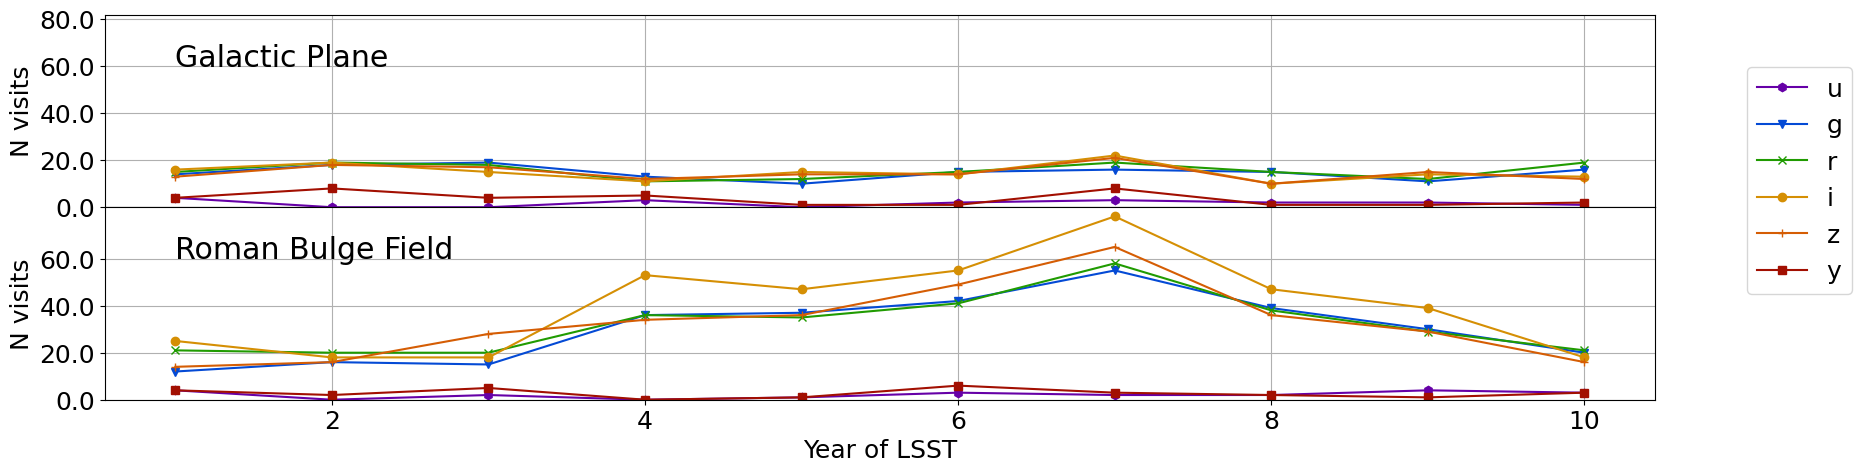

In [45]:
fig, axs = plt.subplots(2, 1, figsize=(20,5))
fig.subplots_adjust(hspace=0)

plot_colours = {'u': '#6600a7', 'g': '#044ad5', 'r': '#209b01', 'i': '#d58f04', 'z': '#d55d04', 'y': '#a20f01'}
plot_markers = {'u': 'h', 'g': 'v', 'r': 'x', 'i': 'o', 'z': '+', 'y': 's'} 

fontsize = 18
dt = 2460000.0

# Plot of number of visits per year for the Plane
survey_years = range(1, 11, 1)
for k,f in enumerate(filters):
    axs[0].plot(survey_years, plane_annual_visits[f], label=f, marker=plot_markers[f], color=plot_colours[f])

    axs[0].set_xlabel('Year of LSST', fontsize=fontsize)
    axs[0].set_ylabel('N visits', fontsize=fontsize)
#axs[0].set_title('Galactic Plane', fontsize=fontsize*1.2)
axs[0].grid()
axs[0].text(1,60,'Galactic Plane', fontsize=fontsize*1.2)
plane_yrange = axs[0].get_ylim()

# Plot of number of visits per year for the Bulge
survey_years = range(1, 11, 1)
for k,f in enumerate(filters):
    axs[1].plot(survey_years, bulge_annual_visits[f], marker=plot_markers[f], color=plot_colours[f])

    axs[1].set_xlabel('Year of LSST', fontsize=fontsize)
    axs[1].set_ylabel('N visits', fontsize=fontsize)
#axs[1].set_title('Galactic Bulge', fontsize=fontsize*1.2)
axs[1].text(1,60,'Roman Bulge Field', fontsize=fontsize*1.2)
bulge_yrange = axs[1].get_ylim()

ymin = min(plane_yrange[0], bulge_yrange[0])
ymin = max(0.0, ymin)
ymax = max(plane_yrange[1], bulge_yrange[1])
axs[0].set_ylim([ymin, ymax])
axs[1].set_ylim([ymin, ymax])
axs[1].grid()
xticklabels = [str(int(x)) for x in axs[1].get_xticks()] # Get current x-tick labels
axs[1].set_xticklabels(xticklabels, fontsize=fontsize)

yticks = np.arange(ymin, ymax, 20.0)
yticklabels = [str(y) for y in yticks] # Get current y-tick labels for both plots
axs[0].set_yticks(yticks)
axs[0].set_yticklabels(yticklabels, fontsize=fontsize)
axs[1].set_yticks(yticks[0:-1])
yticklabels = [str(y) for y in yticks] 
axs[1].set_yticklabels(yticklabels[0:-1], fontsize=fontsize)
    
fig.legend(bbox_to_anchor=(1.005,0.8), ncol=1, fontsize=fontsize)


plt.savefig('./lsst_v4_nvisits_per_year_horiz.png', bbox_inches='tight')